# Regresión Polinomial y Modelos de Predicción: Tiempo vs Calificación


Este proyecto realiza un análisis y limpieza de datos del archivo **"A1.6 Tiempo de entrega.csv"**. Despues, genera gráficos para visualizar la relación entre el **tiempo de entrega** y la **calificación** obtenida.

### 1. Carga y Exploración de Datos
- Se muestran las **dimensiones** del conjunto de datos.
- Se eliminan espacios innecesarios en los nombres de las columnas.
- Se imprime el **tipo de datos** de cada columna para detectar posibles inconsistencias.

#### Limpieza de Datos
La limpieza se realiza en varias etapas:

- Se convierten las columnas `Tiempo` y `Calificación` a formato numérico.
- Se detectan y eliminan filas con valores no numéricos.

- Se eliminan registros donde `Tiempo` o `Calificación` sean menores a 0.
- Se establece un límite superior de 110 para `Calificación`.

- Se calcula el **rango intercuartílico (IQR)** para `Tiempo`.
- Se eliminan valores extremos utilizando un umbral amplio de `k=20` para evitar eliminar datos relevantes.


#### Visualización de Datos
Se generan dos gráficos de dispersión con `matplotlib`:
- **Antes de la limpieza:** Muestra los datos crudos, incluyendo posibles valores atípicos.
- **Después de la limpieza:** Presenta los datos ya filtrados, proporcionando una vista más clara de la tendencia.

#### Predicción del Tipo de Algoritmo
Antes de realizar los modelos mi predicción es que el modelo de segmentos sera el mejor para encontrar mejores predicciones de calificaciones.


Dimensiones de los datos: (443, 2)
Tiempo          float64
Calificacion     object
dtype: object


,Tiempo,Calificacion
0,85.076389,85
1,84.675556,85
2,79.553889,110
3,75.310556,110
4,64.958611,110
5,58.157778,110
6,56.238611,110
7,55.903056,110
8,52.465556,103
9,51.998333,96



Filas eliminadas por contener valores no numéricos:
  Tiempo Calificacion
0.603333          NaN
0.114167          NaN
0.035833          $#%
0.000000          %<>
     NaN          NaN
     NaN          NaN
     NaN          NaN
     NaN          NaN
     NaN          NaN
     NaN          NaN
     NaN          NaN
     NaN          NaN
     NaN          NaN
     NaN          NaN
     NaN          NaN


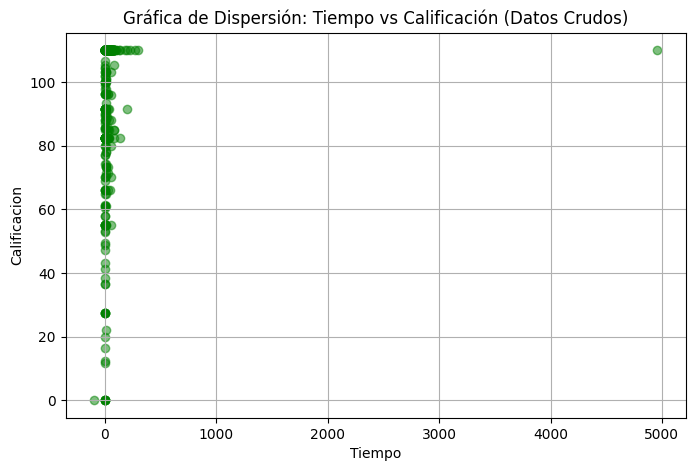


 Valores eliminados por ser negativos:
 Tiempo  Calificacion
 -100.0           0.0

Valores eliminados por ser atípicos en Tiempo (IQR con k=20):
     Tiempo  Calificacion
4960.167000         110.0
 299.986667         110.0
 269.995278         110.0


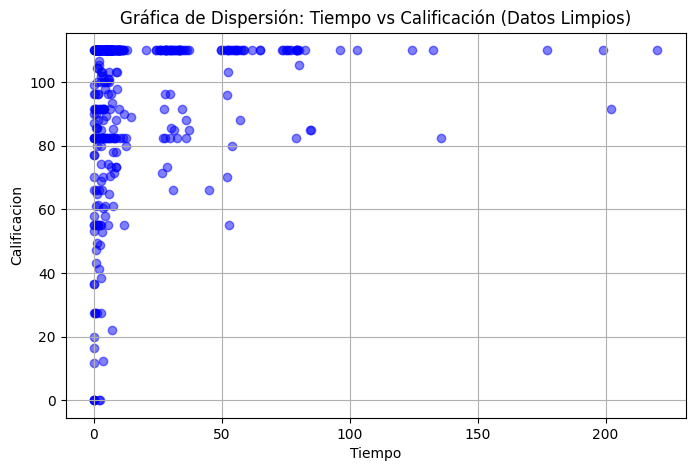

In [103]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from mlinsights.mlmodel import PiecewiseRegressor
from sklearn.neighbors import KNeighborsRegressor as KNN
import statsmodels.api as sm


datos = pd.read_csv("A1.6 Tiempo de entrega.csv")

print(f"Dimensiones de los datos: {datos.shape}")
datos.columns = datos.columns.str.strip()
print(datos.dtypes)
display(datos.head(10))

datos_antes = datos.copy()
datos["Tiempo"] = pd.to_numeric(datos["Tiempo"], errors='coerce')
datos["Calificacion"] = pd.to_numeric(datos["Calificacion"], errors='coerce')
non_numeric_rows = datos_antes[(datos["Tiempo"].isna()) | (datos["Calificacion"].isna())]
print("\nFilas eliminadas por contener valores no numéricos:")
print(non_numeric_rows.to_string(index=False))
datos_antes = datos_antes.dropna(subset=["Tiempo", "Calificacion"])
datos = datos.dropna(subset=["Tiempo", "Calificacion"])

plt.figure(figsize=(8, 5))
plt.scatter(datos["Tiempo"], datos["Calificacion"], color='green', alpha=0.5)
plt.xlabel("Tiempo")
plt.ylabel("Calificacion")
plt.title("Gráfica de Dispersión: Tiempo vs Calificación (Datos Crudos)")
plt.grid(True)
plt.show()


negativos = datos[(datos["Tiempo"] < 0) | (datos["Calificacion"] < 0)]
print("\n Valores eliminados por ser negativos:")
print(negativos.to_string(index=False))
datos = datos[(datos["Tiempo"] >= 0) & (datos["Calificacion"] >= 0) & (datos["Calificacion"] <= 110)]


Q1 = datos["Tiempo"].quantile(0.25)
Q3 = datos["Tiempo"].quantile(0.75)
IQR = Q3 - Q1
k = 20
limite_inferior = Q1 - k * IQR
limite_superior = Q3 + k * IQR
outliers_tiempo = datos[(datos["Tiempo"] < limite_inferior) | (datos["Tiempo"] > limite_superior)]
print("\nValores eliminados por ser atípicos en Tiempo (IQR con k=20):")
print(outliers_tiempo.to_string(index=False))
datos = datos[(datos["Tiempo"] >= limite_inferior) & (datos["Tiempo"] <= limite_superior)]


plt.figure(figsize=(8, 5))
plt.scatter(datos["Tiempo"], datos["Calificacion"], color='blue', alpha=0.5)
plt.xlabel("Tiempo")
plt.ylabel("Calificacion")
plt.title("Gráfica de Dispersión: Tiempo vs Calificación (Datos Limpios)")
plt.grid(True)
plt.show()


### 2. Divide el conjunto de datos en dos subconjuntos:

- Entrenamiento (70%): Utilizado para ajustar el modelo.
- Prueba (30%): Utilizado para evaluar el desempeño del modelo en datos no vistos.

In [104]:
X = datos[['Tiempo']]
y = datos['Calificacion']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=68)

### 3. Regresión Polinomial  
 
Este código entrena un **modelo de regresión polinomial** utilizando los datos de entrenamiento. Se elige un **grado 2** (`degree=2`), lo que permite capturar relaciones no lineales entre el **tiempo de entrega** y la **calificación**.

El modelo sugiere que existe una relación no lineal entre el tiempo de entrega (x1, x2) y la calificación.

- Coeficiente de x1 (término lineal) = 0.3859
Es positivo y estadísticamente significativo (p < 0.001), lo que indica que, en promedio, un mayor tiempo de entrega está asociado con un ligero aumento en la calificación.
- Coeficiente de x2 (término cuadrático) = -0.0018
Es negativo y significativo (p = 0.029), lo que sugiere una posible curvatura en la relación: inicialmente, la calificación aumenta con el tiempo, pero luego tiende a disminuir para valores más altos.


In [105]:

poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)
modelo_poly = sm.OLS(y_train, X_train_poly).fit()
print(modelo_poly.summary())

                            OLS Regression Results                            
Dep. Variable:           Calificacion   R-squared:                       0.056
Model:                            OLS   Adj. R-squared:                  0.050
Method:                 Least Squares   F-statistic:                     8.750
Date:                Thu, 13 Feb 2025   Prob (F-statistic):           0.000204
Time:                        15:42:30   Log-Likelihood:                -1358.0
No. Observations:                 296   AIC:                             2722.
Df Residuals:                     293   BIC:                             2733.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         89.6953      1.807     49.645      0.0

### 4. Regresión Segmentada  
 
Aqui se entrena un **modelo de regresión segmentada** utilizando la clase `PiecewiseRegressor`. Se emplean **regresiones cuadráticas en cada segmento**, lo que permite capturar patrones locales en los datos en lugar de asumir una relación global única.    


In [106]:
modelo_seg = PiecewiseRegressor('bins').fit(X_train_poly[:, 1:], y_train)
y_seg = modelo_seg.predict(X_test_poly[:, 1:])

### 5. Regresión KNN  

Se entrena un **modelo de regresión K-Nearest Neighbors (KNN)** utilizando `KNeighborsRegressor` de `sklearn`. La cantidad de vecinos (`k`) se establece en **5**, aunque este valor puede ajustarse según el comportamiento de los datos.  

Este enfoque es útil cuando la relación entre las variables es compleja o no lineal.



In [107]:
modelo_knn = KNN(n_neighbors=5).fit(X_train, y_train)
y_knn = modelo_knn.predict(X_test)

### Cálculo y Comparación del Error RSE

Se imprime la comparación de los valores de **RSE** para los tres modelos. No solo el error debe tomarse en cuenta para elegir el mejor modelo.  

In [108]:
RSS_poly = sum((y_test - modelo_poly.predict(X_test_poly))**2)
RSE_poly = np.sqrt(RSS_poly / (len(y_test) - 1))
RSS_seg = sum((y_test - y_seg)**2)
RSE_seg = np.sqrt(RSS_seg / (len(y_test) - 1))
RSS_knn = sum((y_test - y_knn)**2)
RSE_knn = np.sqrt(RSS_knn / (len(y_test) - 1))

print("\nComparación de errores (RSE):")
print(f"Regresión Polinomial: {RSE_poly:.2f}")
print(f"Regresión Segmentada: {RSE_seg:.2f}")
print(f"KNN: {RSE_knn:.2f}")


Comparación de errores (RSE):
Regresión Polinomial: 21.68
Regresión Segmentada: 21.36
KNN: 22.74


### Visualización de Comparación de Modelos  

Este código genera una **gráfica de dispersión** que compara las calificaciones reales con las predicciones realizadas por los tres modelos entrenados:   
- Predicciones de la Regresión Polinomial: En color rojo 
- Predicciones de la Regresión Segmentada: En color verde  
- Predicciones del Modelo KNN: En color azul   

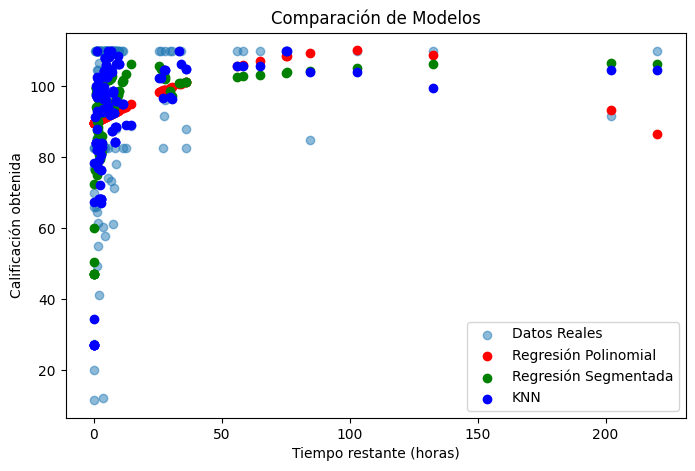

In [109]:

plt.figure(figsize=(8, 5))
plt.scatter(X_test, y_test, label='Datos Reales', alpha=0.5)
plt.scatter(X_test, modelo_poly.predict(X_test_poly), color='r', label='Regresión Polinomial')
plt.scatter(X_test, y_seg, color='g', label='Regresión Segmentada')
plt.scatter(X_test, y_knn, color='b', label='KNN')
plt.xlabel("Tiempo restante (horas)")
plt.ylabel("Calificación obtenida")
plt.legend()
plt.title("Comparación de Modelos")
plt.show()


### Conclusión

Este análisis busca determinar si existe una relación entre el **tiempo de entrega** y la **calificación obtenida**. A través de diferentes modelos de predicción, se exploraron patrones en los datos para evaluar si entregar una tarea más cerca de la fecha límite afecta el desempeño académico.  

Los resultados muestran que **existe una relación**, aunque no es completamente lineal. Algunos modelos sugieren que las calificaciones pueden verse afectadas en ciertos rangos de tiempo, pero otros factores también influyen en los resultados.  

En términos de desempeño, la **regresión segmentada** fue el modelo con mejor ajuste a los datos, aunque cada enfoque tiene ventajas y limitaciones dependiendo del contexto.  

### Referencias

Dr. Antonio Martínez Torteya. (2022). A1.6 Tiempo de Entrega.csv [Base de datos sobre entregas y calificaciones en Sistemas Digitales]. Universidad de Monterrey.
